In [1]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import numpy as np
import pickle

import tensorflow as tf
import keras

## If Error, change keras -> tensorflow.keras

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dense, Reshape
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model

from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import QED
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import import_ipynb
import sascorer
import keras


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from FPSim2 import FPSim2Engine
#from FPSim2 import FPSim2CudaEngine
from FPSim2.io import create_db_file
import time
import linecache
from collections import defaultdict

from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Using TensorFlow backend.


importing Jupyter notebook from sascorer.ipynb


In [2]:
## https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def evaluate_components(fp_list):
    res = []
    for n_comp in tqdm(range(2,50)):
        pca = PCA(n_components=n_comp)
        crds = pca.fit_transform(fp_list) 
        var = np.sum(pca.explained_variance_ratio_)
        res.append([n_comp,var])
    return res

In [9]:
df_AB = pd.read_csv('generated_molecules/A8B8_pool_500.csv', index_col = 0)
df_AG = pd.read_csv('generated_molecules/A8G8_pool_500.csv', index_col = 0)
df_GB = pd.read_csv('generated_molecules/G8B8_pool_500.csv', index_col = 0)

In [10]:
df_AB

,smiles_g,A_Best,A_score,B_Best,B_score,epoch,generator,Target,QED_score,SA_score,MW,LogP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,CCC(=O)N1CCN(C)c2ccc(O)cc21,CN1CCc2cc(C(=O)CCC3CCN(Cc4ccccc4)CC3)ccc21,0.255102,CCN=S1(=O)CC(C)(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F)...,0.177570,68,AtoB,AB(high) MTDL,0.781177,2.354873,220.272,1.58500,3,1,43.78,1,1,0
1,CC(=O)NC1CCSc2ccc(O)cc2C1(C)C,CCc1ccccc1NC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,0.213592,CC1(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F)CCSC(N)=N1,0.226804,68,AtoB,AB(high) MTDL,0.820487,3.349657,265.378,2.67030,3,2,49.33,1,1,0
2,CC1CC=[N+]2C1=CCN2C(C)(C)C,CCc1ccccc1NC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,0.110000,COC1CCC2(CC1)Cc1ccc(C#CC(C)(C)C)cc1C21N=C(N)N(...,0.150000,68,AtoB,AB(high) MTDL,0.515620,4.989202,179.287,2.02250,1,0,6.25,0,0,1
3,CC1CC(NCC=O)c2ccc[n+]([O-])c21,CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCO)c3C(C1)C2,0.136842,COc1cccc(NC(=O)c2cnc(C34COC(C)CC3CSC(N)=N4)s2)n1,0.140187,68,AtoB,AB(high) MTDL,0.448729,4.312382,206.245,0.65680,3,1,56.04,3,1,3
4,CCC(=O)C1CCN2C(C)=CCC12,CCc1ccccc1NC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,0.142857,Cc1cn(C(F)F)nc1C(=O)Nc1csc(C23COC(C)CC2CSC(N)=...,0.135922,68,AtoB,AB(high) MTDL,0.645574,4.078477,179.263,1.96350,2,0,20.31,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52384,COc1cc2c(cc1NC(=O)CCc1ccn(Cc3ccccc3)c1)C(=O)CC2,COc1cc2c(cc1OC)SC(C(=O)CCc1cc[n+](Cc3ccccc3)cc...,0.401639,COC1CCC2(CC1)Cc1ccc(-c3cncc(F)c3)cc1C21N=C(N)N...,0.296552,34499,BtoA,AB(high) MTDL,0.658372,2.362109,388.467,4.24520,3,1,60.33,7,3,0
52385,COc1ccc2c(c1)c(CCC1CCN(Cc3ccccc3)CC1)c(C#N)o2,COc1ccc2onc(CCC3CCN(Cc4ccccc4)CC3)c2c1,0.728261,CN1C(=O)C2(N=C1N)c1cc(CCC3CC3)ccc1OC21CCc2cccc...,0.305344,34499,BtoA,AB(high) MTDL,0.598030,2.407411,374.484,5.15788,4,0,49.40,6,3,0
52386,COc1ccc2c(c1)C(=O)C(CCc1ccc[n+](Cc3ccccc3)c1)CC2,COc1ccc2c(c1)CCC(Cc1cc[n+](Cc3ccccc3C)cc1C(C)=...,0.491228,COC1CCC2(CC1)Cc1ccc(-c3cncc(F)c3)cc1C21N=C(N)N...,0.300699,34499,BtoA,AB(high) MTDL,0.600173,2.962164,372.488,4.40890,2,0,30.18,6,3,1
52387,COc1ccc2c(c1)c(CCC1CCN(Cc3ccccc3)CC1)co2,COc1ccc2onc(CCC3CCN(Cc4ccccc4)CC3)c2c1,0.770115,CN1C(=O)C2(N=C1N)c1cc(CCC3CC3)ccc1OC21CCc2cccc...,0.307087,34499,BtoA,AB(high) MTDL,0.604819,2.080328,349.474,5.28620,3,0,25.61,6,3,0


# Chemical Diversity

#### Similiarty searching within the generated molecules

In [4]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [4]:
AB_fpe = FPSim2Engine('similarity_searching/AB_smiles_g_morgan2_2048.h5')
AB_smi = 'similarity_searching/AB_smiles_g.smi'
AG_fpe = FPSim2Engine('similarity_searching/AG_smiles_g_morgan2_2048.h5')
AG_smi = 'similarity_searching/AG_smiles_g.smi'
GB_fpe = FPSim2Engine('similarity_searching/GB_smiles_g_morgan2_2048.h5')
GB_smi = 'similarity_searching/GB_smiles_g.smi'

In [4]:
def getmol(chemblsmi, index):
    smi = linecache.getline(chemblsmi, index).rstrip()
    linecache.clearcache()
    return smi

In [8]:
# downloadable at https://zenodo.org/records/2543724 
excape = pd.read_csv('ExCAPE/pubchem.chembl.dataset4publication_inchi_smiles.tsv', delimiter = '\t')

In [13]:
# downloadable at Zenodo (see GitHub note)
chembl27_sm = pd.read_csv('ChEMBL27_small_molecules.csv', index_col = 0)

C:\Users\TY\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\TY\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
len(excape['SMILES'].unique())

1324185

In [15]:
len(chembl27_sm['Smiles'].unique())

1914429

In [18]:
smiles_g = ""
for smile in excape['SMILES'].unique():
    smiles_g += str(smile)
    smiles_g += '\n'
with open('similarity_searching/excape_smiles_g.smi', 'w') as out_file:
    out_file.write(smiles_g)
create_db_file('similarity_searching/excape_smiles_g.smi',
              'similarity_searching/excape_smiles_g_morgan2_2048.h5',
              'Morgan', {'radius':2, 'nBits':2048})

In [19]:
excape_fpe = FPSim2Engine('similarity_searching/excape_smiles_g_morgan2_2048.h5')
excape_smi = 'similarity_searching/excape_smiles_g.smi'

In [15]:
from FPSim2 import FPSim2CudaEngine
chembl_fpe = FPSim2CudaEngine('similarity_searching/chembl27_sm_morgan2_2048.h5')
chembl_smi = 'similarity_searching/chembl27_sm.smi'

In [11]:
chembl_fpe = FPSim2Engine('similarity_searching/chembl27_sm_morgan2_2048.h5')
chembl_smi = 'similarity_searching/chembl27_sm.smi'

In [16]:
def chembl_search(fpe, chemblsmi, input_smiles, cutoff):
    search = defaultdict(list)
    
    for query_smile in input_smiles:
        results = fpe.similarity(query_smile, cutoff)
        if len(results) < 1: ## need to have at least two matches (one itself and the other second best)
            tcs = 'No Matching'
            match_smiles = 'No Matching'
            match_mols = 'No Matching'
        
        else:
            result = results[0] # The best matching
            tcs = result[1] # score
            match_smiles = getmol(chemblsmi, result[0])
            #match_mols = Chem.MolFromSmiles(match_smiles)
            
        search['query_smiles'].append(query_smile)
        search['match_score'].append(tcs)
        #search['match_mols'].append(match_mols)
        search['match_smiles'].append(match_smiles)
    
    df_search = pd.DataFrame(search)
#    for col in df_search.columns[1:]:
#        for i,r in df_search.iterrows():
#            r[col] = r[col][0]
    return df_search

In [23]:
start = time.process_time()
df_AB_excape = chembl_search(fpe = excape_fpe, chemblsmi = excape_smi,
                              input_smiles = df_AB['smiles_g'].to_list(),
                              cutoff = 0)
print(time.process_time() - start)

17507.25


In [24]:
start = time.process_time()
df_AG_excape = chembl_search(fpe = excape_fpe, chemblsmi = excape_smi,
                              input_smiles = df_AG['smiles_g'].to_list(),
                              cutoff = 0)
print(time.process_time() - start)

9928.265625


In [25]:
start = time.process_time()
df_GB_excape = chembl_search(fpe = excape_fpe, chemblsmi = excape_smi,
                              input_smiles = df_GB['smiles_g'].to_list(),
                              cutoff = 0)
print(time.process_time() - start)

44939.015625


In [2]:
df_AB_excape = pd.read_csv('similarity_searching/AB_excape.csv', index_col = 0)
df_AG_excape = pd.read_csv('similarity_searching/AG_excape.csv', index_col = 0)
df_GB_excape = pd.read_csv('similarity_searching/GB_excape.csv', index_col = 0)

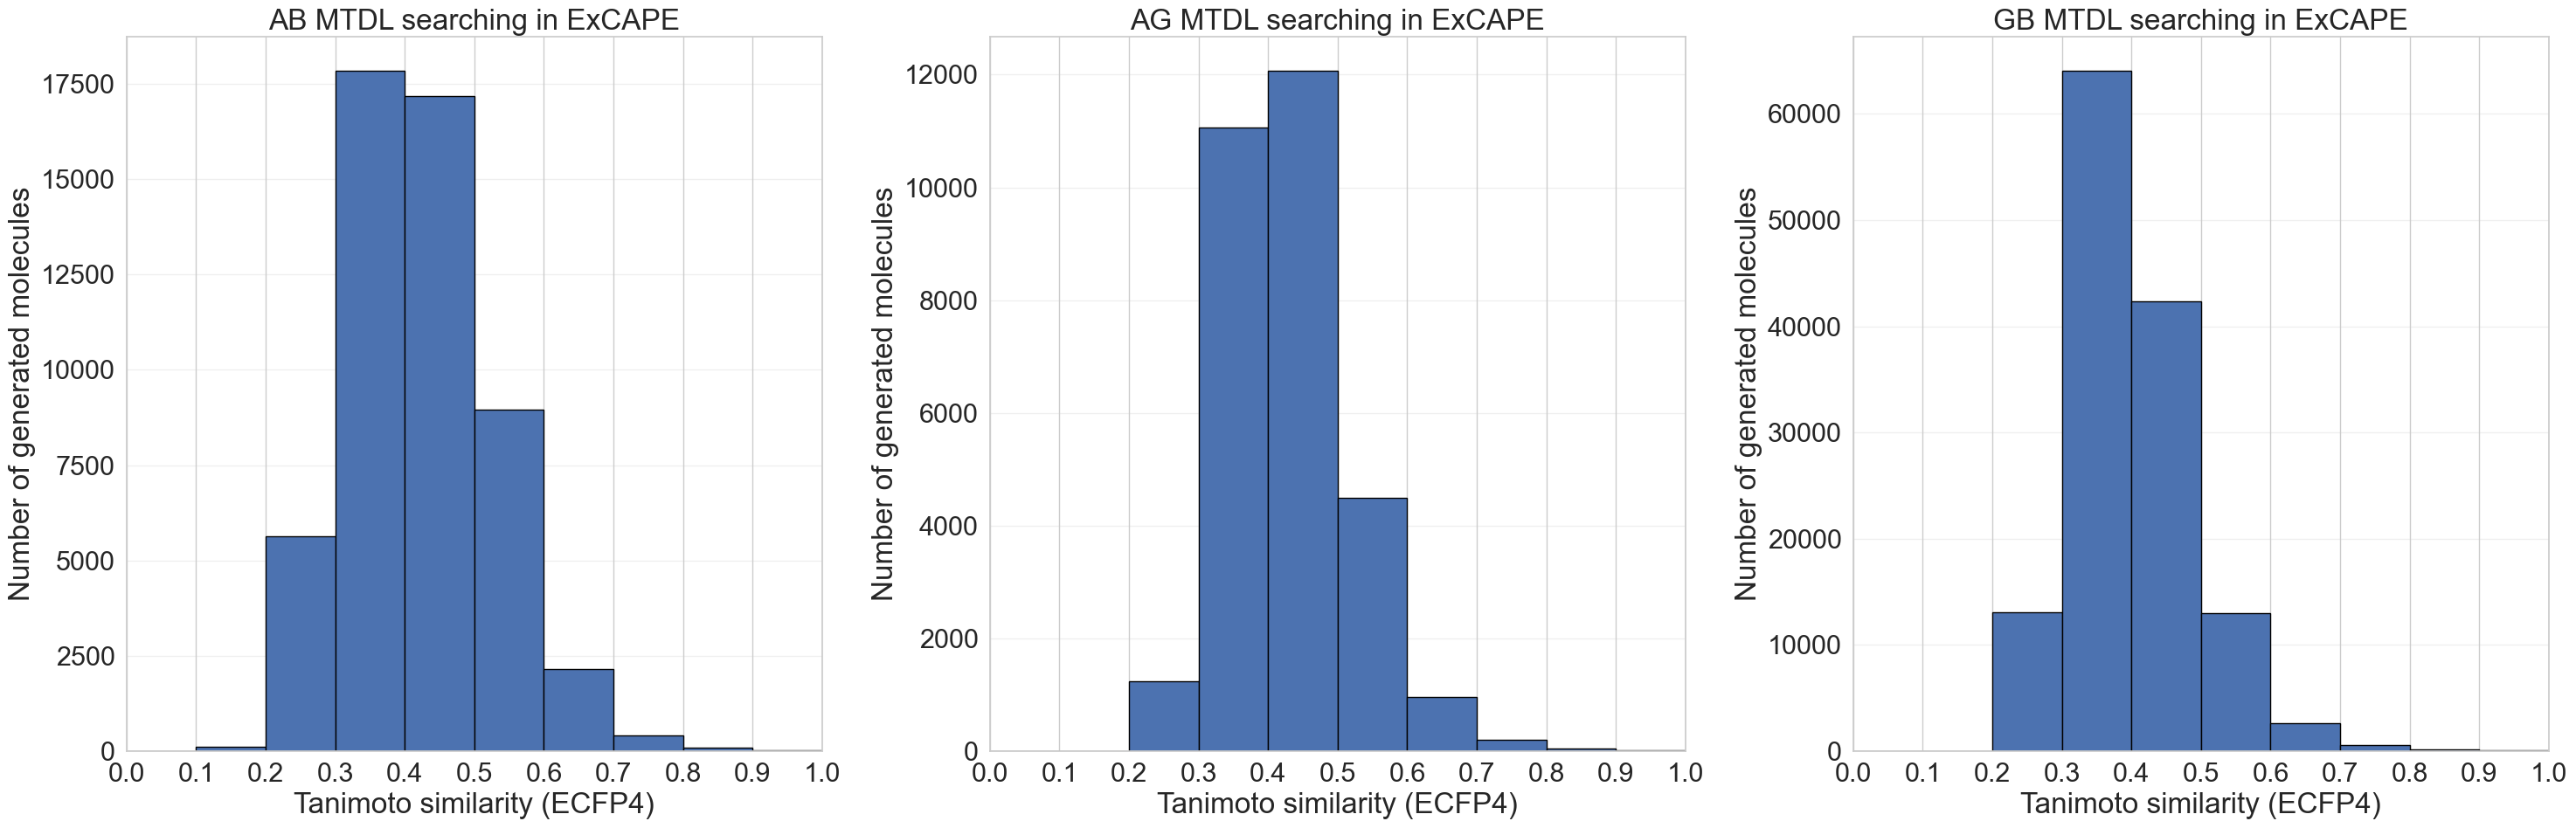

In [21]:
sns.set(rc={'figure.figsize': (30, 10)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

bins = np.linspace(0, 1, 11)
xticks = np.arange(0, 1.01, 0.1)
ylabel = 'Number of generated molecules'

fig, axes = plt.subplots(figsize=(30, 10), ncols=3)

axes[0].hist(df_AB_excape['match_score'], bins=bins, edgecolor='black')
axes[0].set(title='AB MTDL searching in ExCAPE',
            xlabel='Tanimoto similarity (ECFP4)',
            ylabel=ylabel)
axes[0].set_xlim(0, 1)
axes[0].set_xticks(xticks)

axes[1].hist(df_AG_excape['match_score'], bins=bins, edgecolor='black')
axes[1].set(title='AG MTDL searching in ExCAPE',
            xlabel='Tanimoto similarity (ECFP4)',
            ylabel=ylabel)
axes[1].set_xlim(0, 1)
axes[1].set_xticks(xticks)

axes[2].hist(df_GB_excape['match_score'], bins=bins, edgecolor='black')
axes[2].set(title='GB MTDL searching in ExCAPE',
            xlabel='Tanimoto similarity (ECFP4)',
            ylabel=ylabel)
axes[2].set_xlim(0, 1)
axes[2].set_xticks(xticks)

for ax in axes:
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('result_fig/ExCAPE_similarity.png', dpi=300, bbox_inches='tight')


In [29]:
print(df_AB_excape[df_AB_excape['match_score'] > 0.85].shape,
      df_AG_excape[df_AG_excape['match_score'] > 0.85].shape,
      df_GB_excape[df_GB_excape['match_score'] > 0.85].shape)

(53, 3) (25, 3) (117, 3)


In [10]:
## cuda

start = time.process_time()
df_AB_chembl = chembl_search(fpe = chembl_fpe, chemblsmi = chembl_smi,
                              input_smiles = df_AB['smiles_g'].to_list(),
                              cutoff = 0)
print(time.process_time() - start)

8622.859375


In [13]:
## cpu n_workers = 40

start = time.process_time()
df_AG_chembl = chembl_search(fpe = chembl_fpe, chemblsmi = chembl_smi,
                              input_smiles = df_AG['smiles_g'].to_list(),
                              cutoff = 0)
print(time.process_time() - start)

6319.015625


In [17]:
## cuda

start = time.process_time()
df_GB_chembl = chembl_search(fpe = chembl_fpe, chemblsmi = chembl_smi,
                              input_smiles = df_GB['smiles_g'].to_list(),
                              cutoff = 0)
print(time.process_time() - start)

22313.546875


In [22]:
df_AB_chembl = pd.read_csv('similarity_searching/AB_chembl.csv', index_col = 0)
df_AG_chembl = pd.read_csv('similarity_searching/AG_chembl.csv', index_col = 0)
df_GB_chembl = pd.read_csv('similarity_searching/GB_chembl.csv', index_col = 0)

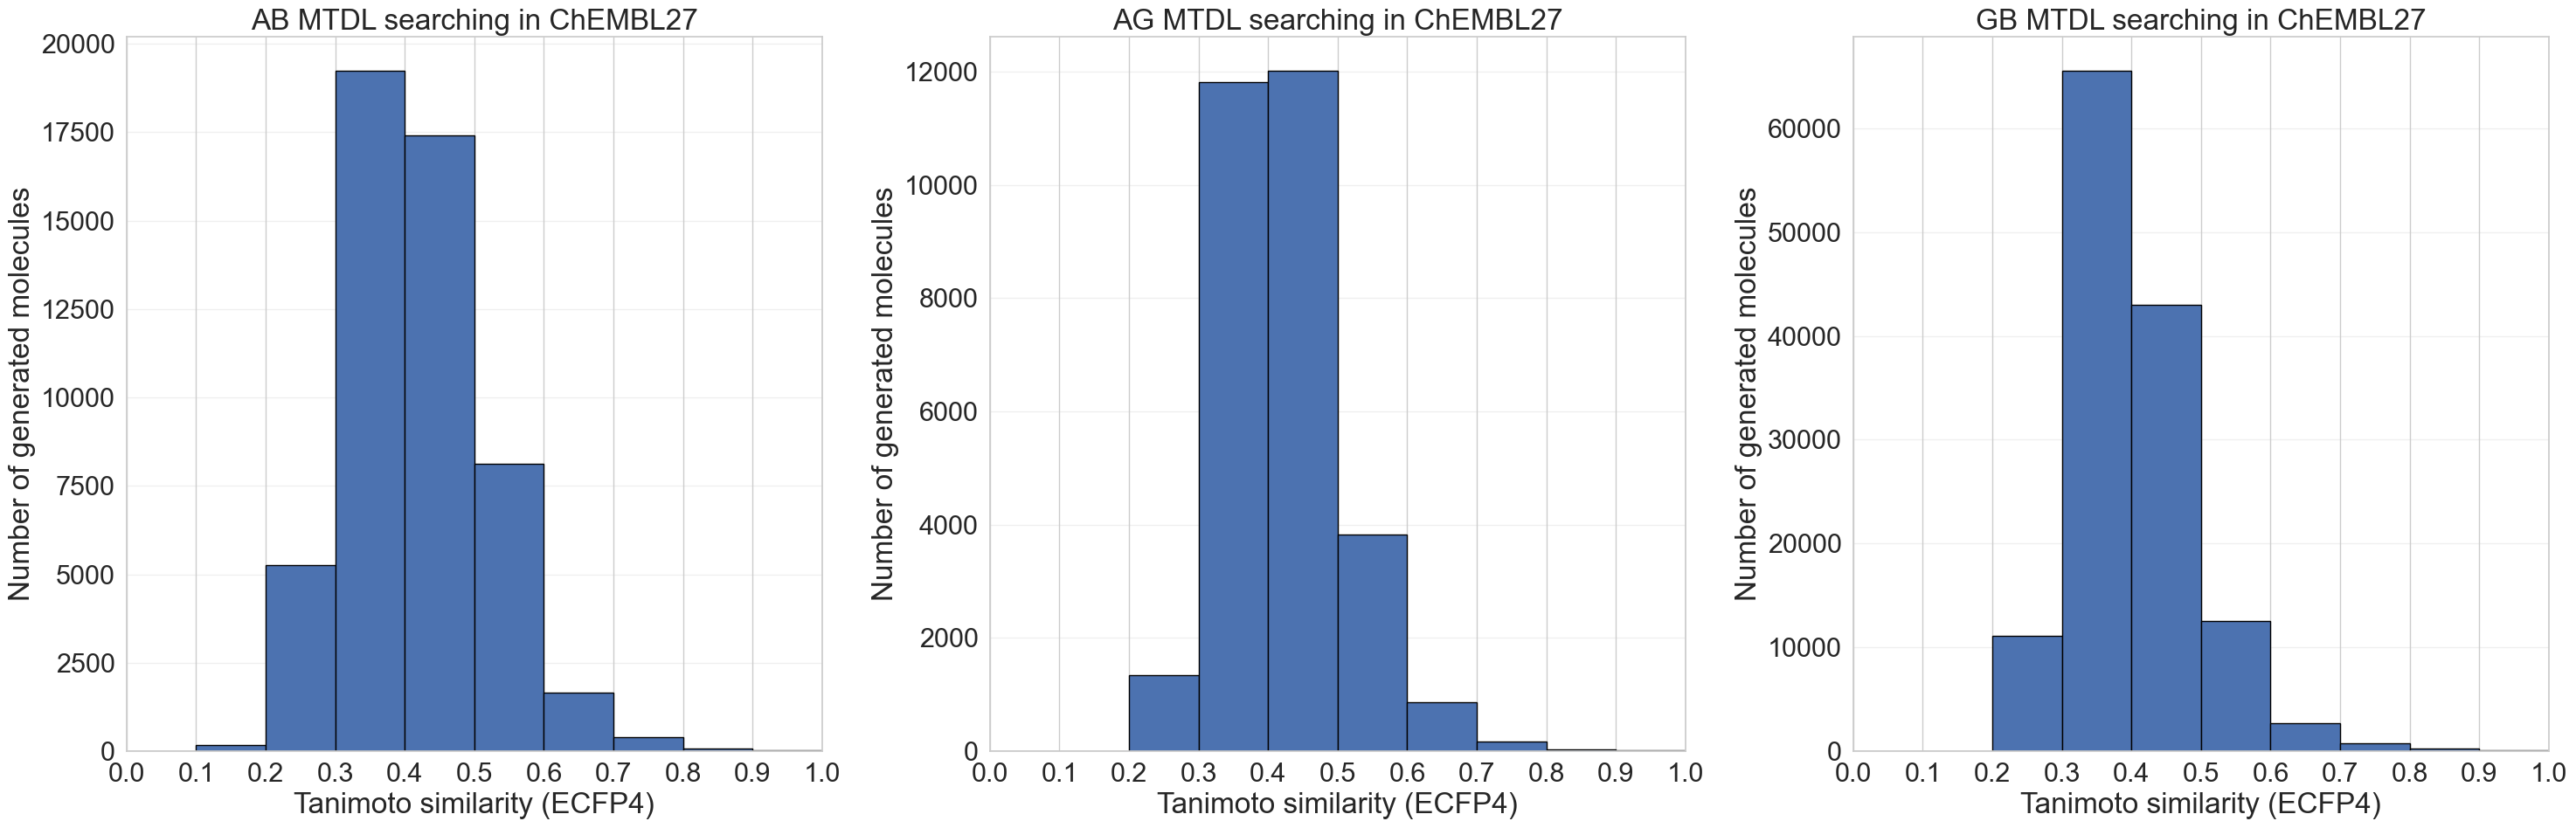

In [24]:
sns.set(rc={'figure.figsize': (30, 10)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

bins = np.linspace(0, 1, 11)
xticks = np.arange(0, 1.01, 0.1)
ylabel = 'Number of generated molecules'

fig, axes = plt.subplots(figsize=(30, 10), ncols=3)

axes[0].hist(df_AB_chembl['match_score'], bins=bins, edgecolor='black')
axes[0].set(title='AB MTDL searching in ChEMBL27',
            xlabel='Tanimoto similarity (ECFP4)',
            ylabel=ylabel)
axes[0].set_xlim(0, 1)
axes[0].set_xticks(xticks)

axes[1].hist(df_AG_chembl['match_score'], bins=bins, edgecolor='black')
axes[1].set(title='AG MTDL searching in ChEMBL27',
            xlabel='Tanimoto similarity (ECFP4)',
            ylabel=ylabel)
axes[1].set_xlim(0, 1)
axes[1].set_xticks(xticks)

axes[2].hist(df_GB_chembl['match_score'], bins=bins, edgecolor='black')
axes[2].set(title='GB MTDL searching in ChEMBL27',
            xlabel='Tanimoto similarity (ECFP4)',
            ylabel=ylabel)
axes[2].set_xlim(0, 1)
axes[2].set_xticks(xticks)

for ax in axes:
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('result_fig/ChEMBL27_similarity.png', dpi=300, bbox_inches='tight')


In [25]:
print(df_AB_chembl[df_AB_chembl['match_score'] > 0.85].shape,
      df_AG_chembl[df_AG_chembl['match_score'] > 0.85].shape,
      df_GB_chembl[df_GB_chembl['match_score'] > 0.85].shape)

(44, 3) (18, 3) (190, 3)
